In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

# Import Data

In [2]:
import os

# Customised for Windows setup
# os.chdir('/MAST30034-Group-Project/')

In [3]:
# Customised for Mac/Linux setup
raw_data = pd.read_csv("kaggle_bee_vs_wasp/labels.csv")
raw_data['path'] = raw_data['path'].str.replace("\\", "/")

C:\Users\c33041440\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


By removing the low quality photos, we get rid of the is_other instances

In [4]:
high_quality_entries = raw_data[raw_data["photo_quality"] == 1]
high_quality_entries =high_quality_entries[high_quality_entries["label"] != "insect"]

In [5]:
print(high_quality_entries.shape)
high_quality_entries.head()

(4596, 10)


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [6]:
[_,label_num] = np.unique(high_quality_entries["label"].values, return_inverse = True)
high_quality_entries.insert(loc = 0, column = "label_num", value = label_num)

In [7]:
print(high_quality_entries.shape)

for ind, row in high_quality_entries.iterrows():
    if not os.path.exists("kaggle_bee_vs_wasp/" + row['path']):
        #print(row)
        high_quality_entries = high_quality_entries.drop(ind)
        
print(high_quality_entries.shape)

(4596, 11)
(4592, 11)


In [8]:
# No non-insects found in the dataset
list(high_quality_entries["is_other"]).count(1)

0

In [9]:
3 in list(high_quality_entries["label_num"].values)

False

In [10]:
#taking a random sample for faster training time
# high_quality_entries = high_quality_entries.sample(1000)

In [11]:
images_path = high_quality_entries["path"].values.reshape(-1, 1)
labels = high_quality_entries["label"].values.reshape(-1, 1)

# Data

In [12]:
from matplotlib.image import imread
from skimage.transform import resize

In [13]:
images = []

# Read, resize, store
for image_path in images_path:
    img = imread(os.path.join("kaggle_bee_vs_wasp", image_path[0]))
    img = resize(img, (224,224))
    images.append(img)

# Removed wrong size
images_to_remove_indices = []

for im in range(len(images)):
    if images[im].shape != (224,224,3):
        #print(im)
        images_to_remove_indices.append(im)

for index in images_to_remove_indices:
    print(index)

# Remove the labels of the anomalous images
labels_deleted = np.delete(labels, images_to_remove_indices)

for im in reversed(images_to_remove_indices):
    print(im)
    del images[im]
    
image_array = np.array(images)
print('Number of images:', image_array.shape)
print('Number of labels:', labels_deleted.shape)

1667
4030
4030
1667
Number of images: (4590, 224, 224, 3)
Number of labels: (4590,)


In [14]:
# #If you need to check the images.

# #imread outputs integers between 0-255

# images[0]
# f,ax = plt.subplots(3,3)
# for i in range(3):
#     for j in range(3):
#         ax[i,j].imshow(images[i+3*j])

## Encoding the image labels

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# Encode as integers
encoder = LabelEncoder()
transformed_label = encoder.fit_transform(np.ravel(labels_deleted))

print('number of labels:', len(transformed_label))

number of labels: 4590


In [17]:
np.unique(transformed_label, return_counts=True)

# 2468 bees, 2122 wasps

(array([0, 1]), array([2468, 2122], dtype=int64))

In [18]:
# OR baseline

print(max(np.unique(transformed_label, return_counts=True)[1])/len(transformed_label)) 
# 54% is the baseline

0.5376906318082789


In [19]:
# Preserve memory (no VM)
del(raw_data)
del(images_path)
del(high_quality_entries)
del(labels)
del(labels_deleted)
del(images)

# all necessary data is in image_array and transformed_label

# Data augmentation

Split a training set from a validation set first, to prevent data leakage.
Augment a training set.

In [20]:
# Train / validation / test split

from sklearn.model_selection import train_test_split

seeed = 51

# 15% in test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(image_array, transformed_label, 
                                              test_size = 0.15, random_state = seeed, 
                                              stratify = transformed_label)

# of remaining 85%, 18% in validation (~15%)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, 
                                              test_size = 0.18, random_state = seeed, 
                                              stratify = Ytrain)

# Roughly 70% training, 15% validation, 15% in test

print('Total:', image_array.shape, transformed_label.shape)
print('Train:', Xtrain.shape, Ytrain.shape)
print('Val:', Xval.shape, Yval.shape)
print('Test:', Xtest.shape, Ytest.shape)

Total: (4590, 224, 224, 3) (4590,)
Train: (3198, 224, 224, 3) (3198,)
Val: (703, 224, 224, 3) (703,)
Test: (689, 224, 224, 3) (689,)


In [21]:
# Augmented training data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range=90,
    zoom_range=0.4,
    horizontal_flip=True,
    # vertical_flip==True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.3)

# No augmentation on validation
val_generator = keras.preprocessing.image.ImageDataGenerator()

train_generator.fit(Xtrain)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


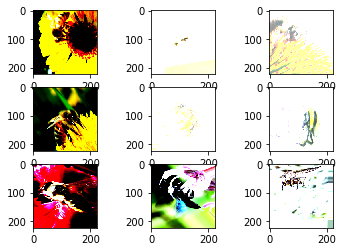

In [22]:
# If images need to be viewed, use batch size 1. Else keep batch size 32

augmented_train = train_generator.flow(Xtrain, Ytrain, batch_size=1)

for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = augmented_train.next()
    # convert to unsigned integers for viewing
    image = batch[0]
#     # plot raw pixel data
    image = np.reshape(image, (224,224,3))
    plt.imshow(image)

In [23]:
# save memory
del(image_array)

# Model Construction

## Metrics: Accuracy and Loss

In [24]:
def plot_model_metrics(hist):
    '''
    Generates two plots:
        1. Training/Validation Accuracy over training epochs
        2. Training/Valiation (cross-entropy) loss over training epochs
    '''
    f, ax = plt.subplots(2,1)
    f.subplots_adjust(hspace=0.6)
    
    ax[0].plot(np.arange(0,len(hist.history['accuracy'])), hist.history['accuracy'])
    ax[0].plot(np.arange(0,len(hist.history['val_accuracy'])), hist.history['val_accuracy'])
    ax[0].legend(['training', 'validation'])

    ax[0].set_xticks(ticks=np.arange(0,len(hist.history['accuracy'])))
    ax[0].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy'])))
    ax[0].set_xlim(0,len(hist.history['accuracy']))
    ax[0].set_xlabel('Epochs')
    ax[0].set_title('Model Accuracy')

    ax[0].set_yticks(ticks=np.arange(round(min(hist.history['accuracy'])-0.04,1), 
                                     round(max(hist.history['accuracy'])+0.16, 1), 
                                     .1))
    
    ax[1].plot(np.arange(0,len(hist.history['loss'])), hist.history['loss'])
    ax[1].plot(np.arange(0,len(hist.history['val_loss'])), hist.history['val_loss'])
    ax[1].legend(['training', 'validation'])

    ax[1].set_xticks(ticks=np.arange(0,len(hist.history['accuracy'])))
    ax[1].set_xticklabels(labels=np.arange(0,len(hist.history['accuracy'])))
    ax[1].set_xlim(0,len(hist.history['accuracy']))
    ax[1].set_xlabel('Epochs')
    ax[1].set_title('Loss')
    
#     ax[1].set_yticks(ticks=np.arange(0,10,0.1))
#     ax[1].set_yticklabels(labels=np.arange(0,11,0.2))
    

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_report(truth, predictions):
    '''
    Input:
        truth - true labels
        predictions - model.predict(data)
    Returns:
        classification_report: recall, precision, f1, etc.
        confusion matrix
    '''
    print(classification_report(truth, np.argmax(predictions, axis=-1)))
    print(confusion_matrix(truth, np.argmax(predictions, axis=-1)))

## Model - MobileNetV2

In [26]:
mbnet = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet')
avg = keras.layers.GlobalAveragePooling2D()(mbnet.output)
drop = keras.layers.Dropout(0.7)(avg)
output = keras.layers.Dense(2, activation='sigmoid')(drop)

m0 = keras.Model(inputs = mbnet.input, outputs = output)

for layer in mbnet.layers:
    layer.trainable = False

# If running on a different machine, we suggest using optimizer "adam".
optimizer = keras.optimizers.SGD(lr=0.2, momentum= 0.9, decay = 0.01)

m0.compile(loss="sparse_categorical_crossentropy", 
           optimizer="adam",
           metrics=["accuracy"])

In [27]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.005, restore_best_weights=True)


h0 = m0.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
            epochs=23, steps_per_epoch=20,
            validation_data = (Xval, Yval),
            callbacks = [callback])

# 1 epoch = training on length len(Xtrain) examples

# Trains 3,200 images
# Validates on len(Yval) (should be entire validation set)

Epoch 1/23
20/20 [==============================] - 41s 2s/step - loss: 0.7444 - accuracy: 0.5531 - val_loss: 0.6284 - val_accuracy: 0.7326
Epoch 2/23
20/20 [==============================] - 36s 2s/step - loss: 0.6702 - accuracy: 0.6109 - val_loss: 0.5980 - val_accuracy: 0.8321
Epoch 3/23
20/20 [==============================] - 34s 2s/step - loss: 0.6320 - accuracy: 0.6734 - val_loss: 0.4977 - val_accuracy: 0.8606
Epoch 4/23
20/20 [==============================] - 33s 2s/step - loss: 0.5656 - accuracy: 0.7469 - val_loss: 0.3569 - val_accuracy: 0.8819
Epoch 5/23
20/20 [==============================] - 35s 2s/step - loss: 0.5759 - accuracy: 0.7344 - val_loss: 0.3139 - val_accuracy: 0.8848
Epoch 6/23
20/20 [==============================] - 34s 2s/step - loss: 0.5179 - accuracy: 0.7797 - val_loss: 0.2963 - val_accuracy: 0.8976
Epoch 7/23
20/20 [==============================] - 35s 2s/step - loss: 0.4730 - accuracy: 0.7828 - val_loss: 0.2849 - val_accuracy: 0.8962
Epoch 8/23
20/20 [==

In [28]:
m0.evaluate(Xtest,Ytest)
# 90% accuracy

22/22 [==============================] - 16s 740ms/step - loss: 0.2254 - accuracy: 0.9086


[0.22544965147972107, 0.9085631370544434]

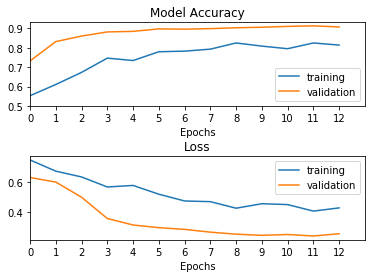

In [29]:
plot_model_metrics(h0)

## Custom-Built Model

Speeding up training:
* Batch normalisation, Adam optimisation

Design options
* Convolution: Window size, Stride
* Activation functions: Softmax, ReLU
* Pooling: Average, Max
* Dense layer - fully connected.

Regularisation options
* Dropout: for regularisation

Other options
* Residual block (resnet)
* Batch normalisation: makes models faster and more stable.

Design recommendations
* Multiple 3x3 convolutions are preferred. (https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15, VGGNet?)
* Downsample by using pooling to reduce spatial information
* Common paradigm is to use max pooling in the network, and average pooling at the end, before the last dense layer
* Depth tends to result in higher accuracy

After all this, try to augment the data:
* rotations
* flips
* slight colour changes (for lighting conditions)

In [30]:
# m1 = keras.models.Sequential()

# m1.add(keras.Input(shape = (224, 224, 3)))

# m1.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding='same'))
# m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# # m1.add(keras.layers.BatchNormalization())

# m1.add(keras.layers.Conv2D(16, 3, activation = 'relu', padding='same'))
# m1.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
# m1.add(keras.layers.BatchNormalization())


# m1.add(keras.layers.Flatten())
# m1.add(keras.layers.Dense(16, activation="relu"))
# m1.add(keras.layers.BatchNormalization())

# # m1.add(keras.layers.Dense(128, activation="relu"))
# # # m1.add(keras.layers.GlobalAveragePooling2D())
# # m1.add(keras.layers.BatchNormalization())
# m1.add(keras.layers.Dense(2, activation="sigmoid"))

# optimizer = keras.optimizers.SGD(lr=0.05, momentum= 0.9, decay = 0.01)

# m1.compile(loss="sparse_categorical_crossentropy",
#            optimizer="adam",
#            metrics=["accuracy"])

In [31]:
# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.005, restore_best_weights=True)

# h1 = m1.fit(train_generator.flow(Xtrain, Ytrain, batch_size=32), 
#             epochs=15, steps_per_epoch=20,
#             validation_data = (Xval, Yval),
#             callbacks=[callback])

# # 32*20 = 640 examples per epoch
# # 15,000/640 = 23 epochs to cycle over the original size * 3

In [32]:
# h1.model.summary()

In [33]:
# # Very poor results
# plot_model_metrics(h1)

In [34]:
# m1.evaluate(Xtest, Ytest)

In [35]:
# confusion_report(Ytest, m1.predict(Xtest))